# Project Description
Beta Bank customers are leaving: little by little, chipping away every month.
The bankers figured out it’s cheaper to save the existing customers rather than
to attract new ones.
We need to predict whether a customer will leave the bank soon. You have the
data on clients’ past behavior and termination of contracts with the bank.

# Project's Goal
Predict whether a customer will leave the bank soon.

We will Build a model with the maximum possible F1 score. To pass the project, We
need an F1 score of at least 0.59. Check the F1 for the test set.
Additionally, we will measure the AUC-ROC metric and compare it with the F1.

# Table of Contents

 * [ Load, overview and prepare the data](#chapter1)
     * [Encoding categorical features](#section_1_1)
     * [Scaling numeric features](#section_1_2)
     * [imputing missing values](#section_1_3)


 * [Classes examination & model training without taking into account the imbalance](#chapter2)
 
    * [Logistic Regression classifier](#section_2_1)
    * [RFC](#section_2_2)
    * [CatBoost Classifier](#section_2_3)
    * [ANN](#section_2_4)        
        
        
 * [Quality of models improvment , taking into account the imbalance of classes.](#chapter3)
  
   * [Observation of the balance between classes](#section_3_1)
   * [Using Class_Weight:LogisticRegression](#section_3_2)
       * [RFC](#section_3_3)
       * [CatBoost](#section_3_4)
       * [ANN](#section_3_5)  
       
   * [Upsampling](#section_3_6)
       * [LogisticRegression](#section_3_7)
       * [RFC](#section_3_8)
       * [CatBoost](#section_3_9)
       * [ANN](#section_3_10)
   * [Downsampling](#section_3_11)
       * [LogisticRegression](#section_3_12)
       * [RFC](#section_3_13)
       * [CatBoost](#section_3_14)
       * [ANN](#section_3_15) 
   * [Changing Threshold](#section_3_16)
       * [LogisticRegression](#section_3_17)
       * [RFC](#section_3_18)
   * [Hyperparameters tuning](#section_3_19)
       * [RFC](#section_3_20)
       * [CatBoost](#section_3_21)
       
       
 * [Models final testing and validation](#chapter4)
    * [RFC](#section_4_1)
    * [CatBoost](#section_4_2)
    * [Conclusions](#section_4_3)

<a class="anchor" id="chapter1"></a>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Load, overview and prepare the data</h2>
</div>

In [1]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.1 MB 5.8 kB/s ta 0:00:015


In [2]:
!pip install fast_ml

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 42 kB 200 kB/s eta 0:00:01


In [3]:
!pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.3 MB/s eta 0:00:01


Import libraries:

In [4]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import Pool, cv
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from catboost import CatBoostClassifier
from catboost import Pool, cv
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
#from scipy.stats import norm, boxcox
from sklearn.utils import class_weight
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams["figure.figsize"] = (13, 7)

make a try-except block in order to avoid file path error when working both locally and remotely.

In [6]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

Check the table's first 5 rows to see the general information.

In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


We will lower-case our columns names for convinience

In [8]:
df.columns = df.columns.str.lower()

We will create and use another df without  columns rownumber, customerid and surname as they are not useful and can misslead our future model.

In [9]:
df_new = df.drop(['rownumber', 'customerid', 'surname'], axis=1).copy()

before any steps of preprocessing will be taken we will split to train-valid-test sets to simulate a truely unseen new data.
60-20-20 ratio (train,valid,test)

In [10]:
target = df_new['exited']
features = df_new.drop('exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      stratify=y_train,
                                                      random_state=42)

printing the shapes of our created sets:

In [11]:
print('Train set')
print(X_train.shape), print(y_train.shape)
print('\nValidation set')
print(X_valid.shape), print(y_valid.shape)
print('\nTest set')
print(X_test.shape), print(y_test.shape);

Train set
(6000, 10)
(6000,)

Validation set
(2000, 10)
(2000,)

Test set
(2000, 10)
(2000,)


Check the table's general structure

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 1995 to 1215
Data columns (total 10 columns):
creditscore        6000 non-null int64
geography          6000 non-null object
gender             6000 non-null object
age                6000 non-null int64
tenure             5451 non-null float64
balance            6000 non-null float64
numofproducts      6000 non-null int64
hascrcard          6000 non-null int64
isactivemember     6000 non-null int64
estimatedsalary    6000 non-null float64
dtypes: float64(3), int64(5), object(2)
memory usage: 515.6+ KB


We already see we have missing values in tenure column, which will be taken care of.

Checking for missing values and duplicates:

In [13]:
X_train.isna().sum()

creditscore          0
geography            0
gender               0
age                  0
tenure             549
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
dtype: int64

In [14]:
X_train.duplicated().sum()

0

We have 549 rows with missing value for tenure, and we have no duplicates in our train data.

- we can assume tenure value might be missing for new clients in the bank, as it represents how long the clients are clients.
- we will check the exited value for those rows with missing tenure value to see if there is any difference from the total ratio

checking the exited distribution in % in rows with missing tenure value 

In [15]:
df_new[df_new.isna().any(axis=1)].exited.value_counts(normalize=True)*100

0    79.867987
1    20.132013
Name: exited, dtype: float64

checking the exited distribution in % in all rows

In [16]:
df_new.exited.value_counts(normalize=True)*100

0    79.63
1    20.37
Name: exited, dtype: float64

##### Conclusion:
the ratio is nearly the same, and the missing tenure value didnt affect it.

checking the table's initial statistics:

In [17]:
X_train.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
count,6000.000000,6000.000000,5451.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,651.102500,38.959667,5.000367,77261.098155,1.533833,0.709667,0.515500,99452.181700
std,96.645467,10.482144,2.914500,62284.911851,0.584733,0.453954,0.499801,57283.092853
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,50691.817500
50%,652.000000,37.000000,5.000000,97757.240000,1.000000,1.000000,1.000000,99107.435000
75%,717.000000,44.000000,8.000000,128293.950000,2.000000,1.000000,1.000000,147891.152500
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000


the table's numeric features correlations:

In [18]:
X_train.corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
creditscore,1.000000,-0.000656,-0.000703,0.003504,0.015140,0.011097,0.025865,-0.006970
age,-0.000656,1.000000,-0.010336,0.029234,-0.030618,-0.016439,0.082974,0.000158
tenure,-0.000703,-0.010336,1.000000,-0.014802,0.017600,0.026953,-0.023308,0.022184
balance,0.003504,0.029234,-0.014802,1.000000,-0.305426,-0.012615,0.002635,0.023947
numofproducts,0.015140,-0.030618,0.017600,-0.305426,1.000000,0.004357,0.010183,0.013309
hascrcard,0.011097,-0.016439,0.026953,-0.012615,0.004357,1.000000,-0.011020,-0.023134
isactivemember,0.025865,0.082974,-0.023308,0.002635,0.010183,-0.011020,1.000000,-0.013913
estimatedsalary,-0.006970,0.000158,0.022184,0.023947,0.013309,-0.023134,-0.013913,1.000000


plotting our corr table for easier understanding

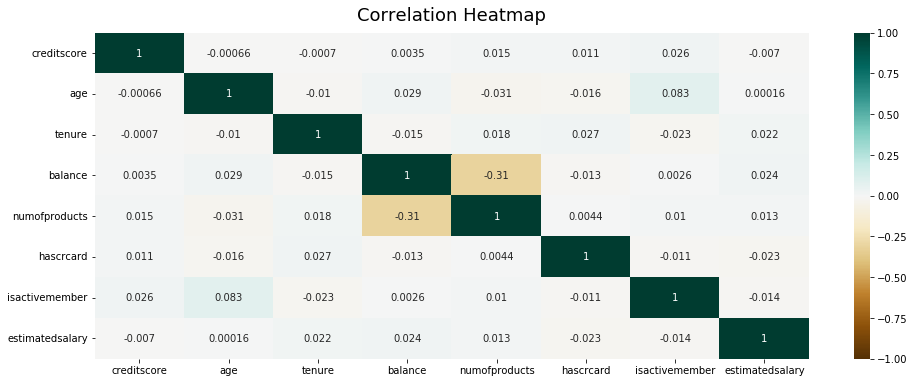

In [19]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### Description:
this heatmap shows the correlation between numeric features in our dataset.
- The strongest correlation (negative corr) is between balance and numofproducts, with value of -0.3.
- We can see tenure (our feature with missing values) doesnt correlate with any feature, as that could have been a way to impute its missing values.

Checking the age distribution for exit status (our target)

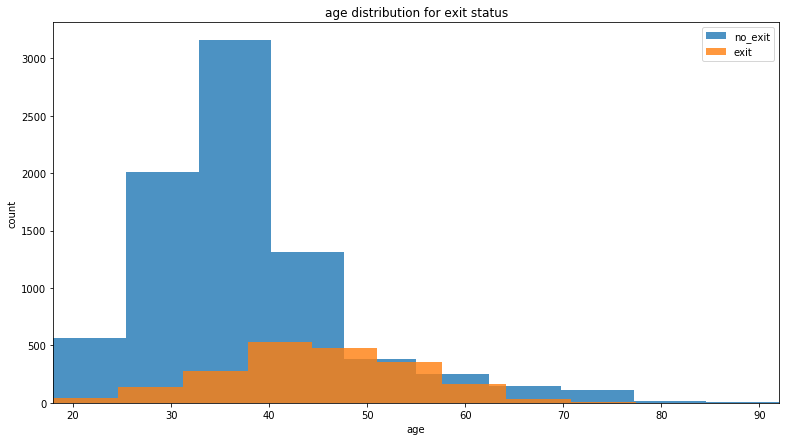

In [20]:
exited = df_new.query('exited == 1')
no_exited = df_new.query('exited == 0')

plt.hist(data = no_exited, x = 'age', alpha = 0.8, bins = 10, label = 'no_exit')
plt.hist(data = exited, x = 'age', alpha = 0.8, bins = 10, label = 'exit')
plt.xlim(df_new.age.min(), df_new.age.max())
plt.legend()
plt.title('age distribution for exit status')
plt.xlabel('age')
plt.ylabel('count');

#### Description:
this graph shows the age distribution for the exit status.
- The relative amount of customers exiting surpasses the amount of customers that doesnt exit around the age of 50.
- we can already tell our classes are imbalanced by the amount of no_exit to exit

We will encode and scale our data before we imputing missing values to be able to compare several imputing methods

<a class="anchor" id="section_1_1"></a>

### Encoding categorical features

checking the categorical features

In [21]:
X_train['geography'].value_counts()

France     2980
Spain      1516
Germany    1504
Name: geography, dtype: int64

In [22]:
X_train['gender'].value_counts()

Male      3276
Female    2724
Name: gender, dtype: int64

encoding using OHE and watching the newly created columns:

(in this case it is fine to use pandas to perform OHE, but generally its better to use sklearn's OneHotEncoder)

In [23]:
X_train= pd.get_dummies(X_train, drop_first=True, prefix='')
X_valid = pd.get_dummies(X_valid, drop_first=True, prefix='')
X_test = pd.get_dummies(X_test, drop_first=True, prefix='')
X_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,_Germany,_Spain,_Male
1995,584,44,5.0,95671.75,2,1,1,106564.88,0,0,0
2724,453,38,NaN,120623.21,1,1,0,129697.99,1,0,0
5224,803,43,3.0,0.00,1,1,0,72051.44,0,1,1
7697,601,41,3.0,0.00,2,1,0,54342.83,0,1,0
1226,531,42,6.0,88324.31,2,1,0,75248.75,1,0,0


checking the new shapes of the sets:

In [24]:
print('Train set')
print(X_train.shape), print(y_train.shape)
print('\nValidation set')
print(X_valid.shape), print(y_valid.shape)
print('\nTest set')
print(X_test.shape), print(y_test.shape);

Train set
(6000, 11)
(6000,)

Validation set
(2000, 11)
(2000,)

Test set
(2000, 11)
(2000,)


<a class="anchor" id="section_1_2"></a>

### Scaling numeric features

Scaling features across the entire dataset can lead to a data leak. We will only fit the scaler on the train set.
We will then use the fitted scaler and apply it to our other sets.

In [25]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

<a class="anchor" id="section_1_3"></a>

### Imputing missing values:

Creating a function to compare imputation strategies and checking it on our train set:

In [26]:
# model = LogisticRegression(random_state=42,solver='liblinear')
# imputer = KNNImputer()
# # pipeline = Pipeline(teps=[('i', imputer), ('m', model)])
# # define model evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# # evaluate model
# scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# print('Meanf1: %.3f (%.3f)' % (mean(scores), std(scores)))

In [27]:
def impute_score(features, target, scoring):
    results = []
    strategies = ['mean', 'median', 'most_frequent', 'constant']
    #by leaving constast empty, it will fill with default value of 0.
    for s in strategies:
    # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', LogisticRegression(random_state=42,solver='liblinear'))])
    # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
        scores = cross_val_score(pipeline, features, target, scoring=scoring, cv=cv, n_jobs=-1)
    # store results
        results.append(scores)
        print('>%s %.3f (%.3f std)' % (s, mean(scores), std(scores)))
    # plot model performance for comparison
    pyplot.boxplot(results, labels=strategies, showmeans=True)
    pyplot.title('{} score for imputing methods'.format(scoring))
    pyplot.show()

>mean 0.312 (0.030 std)
>median 0.312 (0.030 std)
>most_frequent 0.312 (0.029 std)
>constant 0.311 (0.031 std)


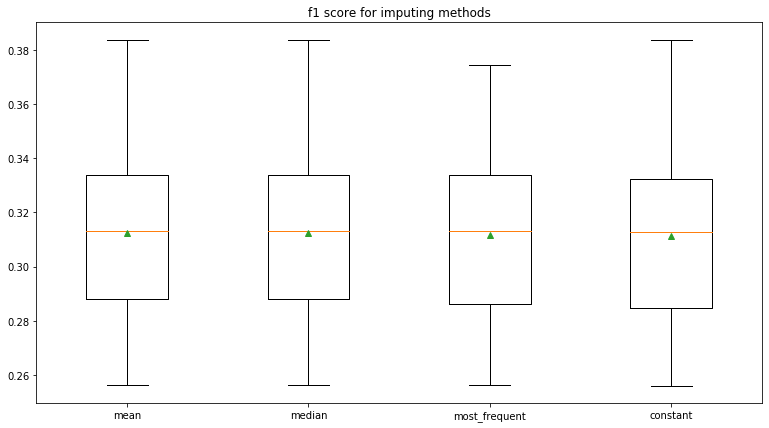

In [28]:
impute_score(X_train, y_train, 'f1')

#### Description & conclusion:
This boxplot shows the f1 scores for the tested imputing methods:

- As the scores being fairly even, we will use the median strategy to fill the missing values to keep the current balance of the data

applying the imputation for our sets:

In [29]:
for i in [X_train, X_valid, X_test]:
    imp = SimpleImputer(strategy='median')
    imp = imp.fit(i[['tenure']])
    i['tenure'] = imp.transform(i[['tenure']])

### Conclusions:

We've previewed & prepared our dataset:

- we splitted our data into train,validation and test sets (60%,20%,20% respectively)
- no duplicates found, no need to delete rows.
- the columns customer_id,row_number and surname got removed.
- missing values were found in tenure column
- tenure column doesnt correlate with any existing feature in our data, hence we need to use a general imputation method.
- categorical features (geography, gender) got encoded using OHE encoding method.
- numeric features got scaled using standard scaler.
- missing values were imputed using median strategy after comparing several imputation methods.

<a class="anchor" id="chapter2"></a>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Classes examination & model training without taking into account the imbalance</h2>
</div>

#### examination of classes balance:

In [30]:
for i in [y_train, y_valid, y_test]:
    print(i.value_counts(normalize=True)*100)

0    79.616667
1    20.383333
Name: exited, dtype: float64
0    79.65
1    20.35
Name: exited, dtype: float64
0    79.65
1    20.35
Name: exited, dtype: float64


#### Description:
We see our classes are imbalanced across all of our data-sets, with class 0 (didnt exit) happening 79.6x% of the times

### training of models without considering class imbalance: 

(We will not tune hyper-parameters at this stage, as we will do so when considering the classes imbalance)

<a class="anchor" id="section_2_1"></a>

#### Logistic regression:

In [31]:
model = LogisticRegression(random_state=42,solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.31842576028622543
ROC-AUC: 0.7561845358455528


We got low scores for both F1 and ROC-AUC using basic logistic regression.

<a class="anchor" id="section_2_2"></a>

#### Random Forest Classifier:
We will use min_samples_leaf=5 as the default value.

min_samples_leaf -  the minimum number of samples required to be at a leaf node

In [32]:
model = RandomForestClassifier(random_state=42,min_samples_leaf=5)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.5515055467511886
ROC-AUC: 0.8605708944691997


 F1 score of 0.55, not high enough for our task.

<a class="anchor" id="section_2_3"></a>

#### CatBoost classifier:

(a great algorithm by yandex :})

verbose=  logging level 

custom_loss F1 = we define our loss to be F1 score

In [33]:
model = CatBoostClassifier(verbose=100, custom_loss=['F1'], random_state=42)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

Learning rate set to 0.027819
0:	learn: 0.6704754	total: 51.6ms	remaining: 51.6s
100:	learn: 0.3253721	total: 1.74s	remaining: 15.5s
200:	learn: 0.3028422	total: 3.58s	remaining: 14.2s
300:	learn: 0.2866564	total: 5.36s	remaining: 12.4s
400:	learn: 0.2709867	total: 7.13s	remaining: 10.7s
500:	learn: 0.2566947	total: 8.9s	remaining: 8.87s
600:	learn: 0.2443251	total: 10.6s	remaining: 7.02s
700:	learn: 0.2327841	total: 12.3s	remaining: 5.26s
800:	learn: 0.2217535	total: 14.2s	remaining: 3.53s
900:	learn: 0.2117433	total: 16s	remaining: 1.75s
999:	learn: 0.2028549	total: 17.7s	remaining: 0us
F1: 0.5745007680491552
ROC-AUC: 0.8597195037873003


Decent scores , but still not high enough for our task.

<a class="anchor" id="section_2_4"></a>

#### ANN 

** All the ANN parts have been commented out to not waste the reviewer's time, as the models werent performing and weren't tuned . Commenting out is optional and up to the reviewer

converting all dtypes to float32:

In [34]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')

checking and defining the amount of features and classes for our model

In [35]:
n_features = X_train.shape[1]
n_class = len(np.unique(y_train))
n_features

11

creating a function to use F1 as our NN lose, and as a metric too:

In [36]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

Creating a function to deploy a simple ANN model for us.

In [37]:
def create_ann():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 10,input_dim = n_features,  activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 4, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy',f1])
    return model

Creating a function to plot train / validation metric progress:

In [38]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [39]:
model = create_ann()

fitting the ANN on the training set

In [40]:
history = model.fit(X_train.values, y_train.values, validation_data = (X_valid.values, y_valid.values), epochs = 100)

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 1s 189us/sample - loss: 0.6190 - accuracy: 0.6832 - f1: 0.0970 - val_loss: 0.4788 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 2/100
6000/6000 [==============================] - 1s 101us/sample - loss: 0.4592 - accuracy: 0.7980 - f1: 0.0229 - val_loss: 0.4445 - val_accuracy: 0.7970 - val_f1: 0.0361
Epoch 3/100
6000/6000 [==============================] - 1s 101us/sample - loss: 0.4389 - accuracy: 0.8000 - f1: 0.0711 - val_loss: 0.4336 - val_accuracy: 0.8020 - val_f1: 0.1007
Epoch 4/100
6000/6000 [==============================] - 1s 101us/sample - loss: 0.4319 - accuracy: 0.8032 - f1: 0.1272 - val_loss: 0.4306 - val_accuracy: 0.8040 - val_f1: 0.1422
Epoch 5/100
6000/6000 [==============================] - 1s 100us/sample - loss: 0.4282 - accuracy: 0.8037 - f1: 0.1673 - val_loss: 0.4280 - val_accuracy: 0.8050 - val_f1: 0.2107
Epoch 6/100
6000/6000 [==============================

Predicting the validation results without considering class imbalance (threshold of 0.5 despite imbalance):

In [41]:
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0.5)

In [42]:
print(classification_report(y_valid, y_pred,
          target_names=['0', '1'], zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.73      0.43      0.54       407

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



plotting the f1 progress:

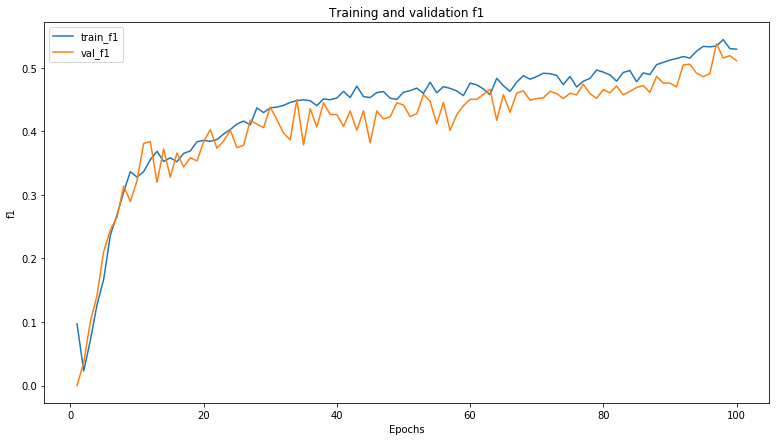

In [43]:
plot_metric(history, 'f1')

In [44]:
f1_score(y_valid, y_pred)

0.543778801843318

##### Description:
This graph shows our training and validation f1 progression:
- our F1 score for the validation set is 0.56

### Conclusion:
- Classes were seen to be imbalanced, with much more observations to class 0.
- RandomForest performed the best when the classes imbalance isnt considered and models aren't tuned with F1 score of 0.592.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Quality of models improvment , taking into account the imbalance of
classes.</h2>
</div>

<a class="anchor" id="section_3_1"></a>

observation of the balance between classes:

In [45]:
y_train.value_counts()

0.0    4777
1.0    1223
Name: exited, dtype: int64

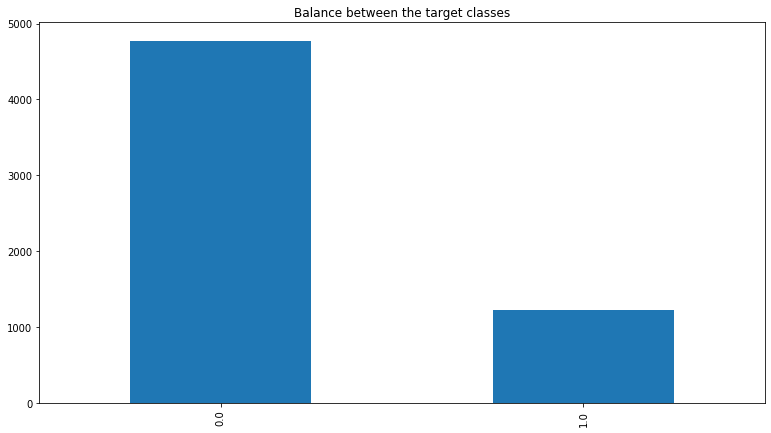

In [46]:
y_train.value_counts().plot(kind='bar',title='Balance between the target classes');

#### Description:
This graph shows our  classes are not balanced, with class 0 being about 4 times more common.

We will use 4 methods in order to try and solve this imbalance:
- adding the class_weight = 'balanced' to our models in order to balance the classes.
- upsampling
- downsampling
- changing the threshold of the probability of the classes

We will then pick the best resulting method and tune our hyperparameters on its balanced data.

<a class="anchor" id="section_3_2"></a>

### Using class_weight hyperparameter:

#### Logistic regression:

In [47]:
model = LogisticRegression(random_state=42,solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.4804270462633452
ROC-AUC: 0.7607653878840319


Big improvement in the F1 score using class_weight='balanced', but still not enough for our task.

<a class="anchor" id="section_3_3"></a>

#### Random forest Classifier:

min_samples_leaf - the minimum number of samples required to be at a leaf node

class_weight='balanced' - gives weights to the classes in order to balance them

In [48]:
model = RandomForestClassifier(random_state=42, class_weight='balanced',min_samples_leaf=5)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.6381418092909535
ROC-AUC: 0.8578532307345867


An incrase from 0.55 to 0.638 using class_weight='balanced'. This score is high enough for our task, althoght it didnt run on the test set yet.

<a class="anchor" id="section_3_4"></a>

#### CatBoost:

For CatBoost we will use class_weights and calculate the class_weights using the compute_class_weight method.

In [49]:
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)

In [50]:
model = CatBoostClassifier(verbose=100, random_state=42, custom_loss=['F1'], class_weights=(class_weights))
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

Learning rate set to 0.027819
0:	learn: 0.6796437	total: 3.35ms	remaining: 3.35s
100:	learn: 0.4365180	total: 1.66s	remaining: 14.8s
200:	learn: 0.4033395	total: 3.62s	remaining: 14.4s
300:	learn: 0.3796966	total: 5.48s	remaining: 12.7s
400:	learn: 0.3562094	total: 7.34s	remaining: 11s
500:	learn: 0.3351664	total: 9.11s	remaining: 9.07s
600:	learn: 0.3145970	total: 10.9s	remaining: 7.22s
700:	learn: 0.2966431	total: 12.8s	remaining: 5.47s
800:	learn: 0.2801893	total: 14.8s	remaining: 3.67s
900:	learn: 0.2650406	total: 16.6s	remaining: 1.82s
999:	learn: 0.2511515	total: 18.3s	remaining: 0us
F1: 0.6211453744493393
ROC-AUC: 0.8552358213375162


Our F1 score increased from 0.57 to 0.62 using class_weights! it can be considered a decent improvment

<a class="anchor" id="section_3_5"></a>

#### ANN:

We will use the same class_weights paramter we calculated for CatBoost to indicate the weight for our ANN.

In [51]:
model = create_ann()

In [52]:
history = model.fit(X_train.values, y_train.values, validation_data = (X_valid.values, y_valid.values), epochs = 100, class_weight = class_weights)

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 1s 200us/sample - loss: 0.6130 - accuracy: 0.7392 - f1: 0.0662 - val_loss: 0.5319 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 2/100
6000/6000 [==============================] - 1s 112us/sample - loss: 0.4939 - accuracy: 0.7962 - f1: 0.0000e+00 - val_loss: 0.4739 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 3/100
6000/6000 [==============================] - 1s 101us/sample - loss: 0.4559 - accuracy: 0.7962 - f1: 0.0000e+00 - val_loss: 0.4483 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 4/100
6000/6000 [==============================] - 1s 102us/sample - loss: 0.4385 - accuracy: 0.7962 - f1: 0.0000e+00 - val_loss: 0.4375 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 5/100
6000/6000 [==============================] - 1s 100us/sample - loss: 0.4304 - accuracy: 0.7962 - f1: 0.0000e+00 - val_loss: 0.4334 - val_accuracy: 0.7965 - val_f1: 0.0000e+00
Epoch 6/100
6000/6000

In [53]:
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0.5)

In [54]:
print(classification_report(y_valid, y_pred,
          target_names=['0', '1'], zero_division=1))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1593
           1       0.71      0.40      0.51       407

    accuracy                           0.84      2000
   macro avg       0.78      0.68      0.71      2000
weighted avg       0.83      0.84      0.83      2000



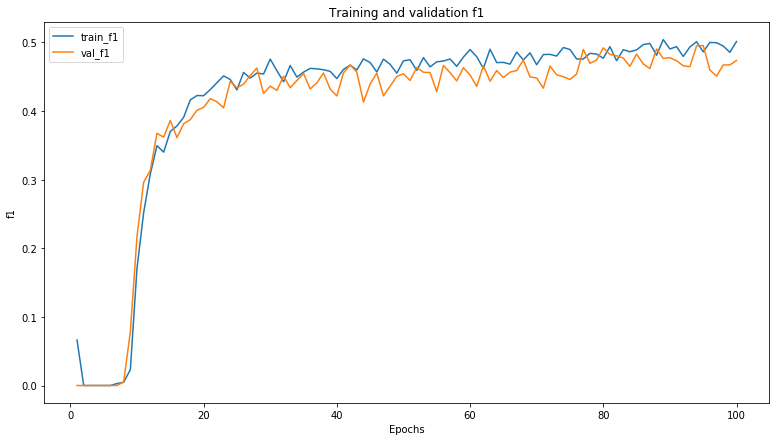

In [55]:
plot_metric(history, 'f1')

In [56]:
f1_score(y_valid, y_pred)

0.5070866141732282

##### Description:
This graph shows the f1 progress through the epochs in both training and validation sets.
- our F1 score for the validation set is 0.55, which is decrease from 0.56.

A small increase in our F1 score using class_weight. (0.56 to 0.55)

<a class="anchor" id="section_3_6"></a>

### Upsampling:

Creating an upsampling function:

In [57]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=42)
    target_upsampled = shuffle(target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

upsampling our training set:

In [58]:
t_features_upsampled, t_target_upsampled = upsample(X_train, y_train, 5)

checking the size of our new upsampled training set:

In [59]:
print(t_features_upsampled.shape)
print(t_target_upsampled.shape)

(10892, 11)
(10892,)


<a class="anchor" id="section_3_7"></a>

#### Logistic Regression:

In [60]:
model = LogisticRegression(random_state=42,solver='liblinear')
model.fit(t_features_upsampled, t_target_upsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.4782608695652174
ROC-AUC: 0.7613514901650495


A slight decrease compared to class_weight (F1 of 0.48)

<a class="anchor" id="section_3_8"></a>

#### Random Forest Classifier:

In [61]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(t_features_upsampled, t_target_upsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.6305309734513275
ROC-AUC: 0.8603673010452672


A small decrease in F1 score(0.638 to 0.630)

<a class="anchor" id="section_3_9"></a>

#### CatBoost:

In [62]:
model = CatBoostClassifier(verbose=100, custom_loss=['F1'], random_state=42)
model.fit(t_features_upsampled, t_target_upsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

Learning rate set to 0.032933
0:	learn: 0.6745860	total: 11.2ms	remaining: 11.2s
100:	learn: 0.4175242	total: 6.26s	remaining: 55.8s
200:	learn: 0.3790955	total: 13.6s	remaining: 54.1s
300:	learn: 0.3493869	total: 19.5s	remaining: 45.2s
400:	learn: 0.3229749	total: 25.2s	remaining: 37.7s
500:	learn: 0.2985503	total: 31.1s	remaining: 31s
600:	learn: 0.2763582	total: 37.1s	remaining: 24.6s
700:	learn: 0.2578282	total: 43.1s	remaining: 18.4s
800:	learn: 0.2409955	total: 49s	remaining: 12.2s
900:	learn: 0.2256275	total: 55.3s	remaining: 6.07s
999:	learn: 0.2121220	total: 1m 1s	remaining: 0us
F1: 0.6092436974789915
ROC-AUC: 0.8537027011603284


A slight decrease in F1 score compared to class_weight (0.62 to 0.60)

<a class="anchor" id="section_3_10"></a>

#### ANN:

In [63]:
model = create_ann()

In [64]:
history = model.fit(t_features_upsampled.values, t_target_upsampled.values, validation_data = (X_valid.values, y_valid.values), epochs = 100)

Train on 10892 samples, validate on 2000 samples
Epoch 1/100
10892/10892 [==============================] - 2s 143us/sample - loss: 0.7002 - accuracy: 0.5747 - f1: 0.6891 - val_loss: 0.6793 - val_accuracy: 0.5720 - val_f1: 0.3941
Epoch 2/100
10892/10892 [==============================] - 1s 98us/sample - loss: 0.5956 - accuracy: 0.6986 - f1: 0.7338 - val_loss: 0.6209 - val_accuracy: 0.6830 - val_f1: 0.4687
Epoch 3/100
10892/10892 [==============================] - 1s 92us/sample - loss: 0.5700 - accuracy: 0.7174 - f1: 0.7478 - val_loss: 0.6297 - val_accuracy: 0.6785 - val_f1: 0.4804
Epoch 4/100
10892/10892 [==============================] - 1s 92us/sample - loss: 0.5600 - accuracy: 0.7214 - f1: 0.7523 - val_loss: 0.6113 - val_accuracy: 0.6910 - val_f1: 0.4898
Epoch 5/100
10892/10892 [==============================] - 1s 92us/sample - loss: 0.5533 - accuracy: 0.7260 - f1: 0.7568 - val_loss: 0.6260 - val_accuracy: 0.6770 - val_f1: 0.4864
Epoch 6/100
10892/10892 [=========================

In [65]:
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0.5)

In [66]:
print(classification_report(y_valid, y_pred,
          target_names=['0', '1'], zero_division=1))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1593
           1       0.47      0.75      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.71      2000
weighted avg       0.83      0.78      0.79      2000



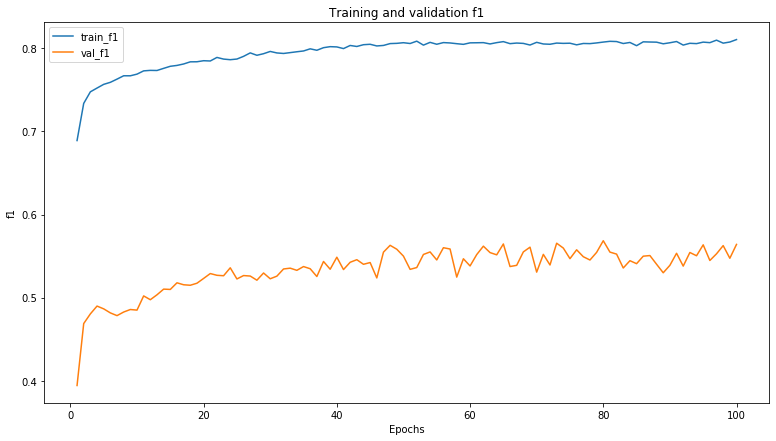

In [67]:
plot_metric(history, 'f1')

In [68]:
f1_score(y_valid, y_pred)

0.576303317535545

#### Description:
This graph shows the progress of F1 score in both validation and training sets:
- We see that using the upsampled data, our ANN seem to perform much better on the training set, while performing worse on the validation set - an indication for overfitting.


<a class="anchor" id="section_3_11"></a>

### Downsampling:

A function to downsample:

In [69]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=42)
    target_sample = target_zeros.sample(frac=0.1, random_state=42)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=42)
    target_downsampled = shuffle(target_downsampled, random_state=42)
    

    
    return features_downsampled, target_downsampled

In [70]:
t_features_downsampled, t_target_downsampled = downsample(X_train, y_train, 0.1)

<a class="anchor" id="section_3_12"></a>

#### Logistic regression:

In [71]:
model = LogisticRegression(random_state=42,solver='liblinear')
model.fit(t_features_downsampled, t_target_downsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.4136389044158748
ROC-AUC: 0.7639087469595944


A decrease from upsampling and class_weight usage.

<a class="anchor" id="section_3_13"></a>

#### RandomForest Classifier:

In [72]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(t_features_downsampled, t_target_downsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

F1: 0.4558823529411765
ROC-AUC: 0.8492514085734424


A major decrease in F1 score (0.63 to 0.45)

<a class="anchor" id="section_3_14"></a>

#### CatBoost:

In [73]:
model = CatBoostClassifier(verbose=100, custom_loss=['F1'], random_state=42)
model.fit(t_features_downsampled, t_target_downsampled)
predicted_valid = model.predict(X_valid)
y_proba_valid = model.predict_proba(X_valid)[:, 1]

print("F1:", f1_score(y_valid, predicted_valid))
print("ROC-AUC:", roc_auc_score(y_valid, y_proba_valid))

Learning rate set to 0.019472
0:	learn: 0.6832716	total: 1.84ms	remaining: 1.84s
100:	learn: 0.3904882	total: 879ms	remaining: 7.82s
200:	learn: 0.3439784	total: 1.85s	remaining: 7.34s
300:	learn: 0.3124322	total: 2.83s	remaining: 6.58s
400:	learn: 0.2853629	total: 3.81s	remaining: 5.7s
500:	learn: 0.2599513	total: 4.79s	remaining: 4.77s
600:	learn: 0.2375026	total: 5.86s	remaining: 3.89s
700:	learn: 0.2167299	total: 6.93s	remaining: 2.95s
800:	learn: 0.1996347	total: 7.82s	remaining: 1.94s
900:	learn: 0.1818863	total: 8.8s	remaining: 967ms
999:	learn: 0.1668262	total: 9.86s	remaining: 0us
F1: 0.492
ROC-AUC: 0.8550599906532111


A major decrease in F1 score (0.60 to 0.49)

<a class="anchor" id="section_3_15"></a>

#### ANN:

In [74]:
model = create_ann()

In [75]:
history = model.fit(t_features_downsampled.values, t_target_downsampled.values, validation_data = (X_valid.values, y_valid.values), epochs = 100)

Train on 1701 samples, validate on 2000 samples
Epoch 1/100
1701/1701 [==============================] - 1s 422us/sample - loss: 0.6799 - accuracy: 0.6420 - f1: 0.7615 - val_loss: 0.7480 - val_accuracy: 0.2030 - val_f1: 0.3322
Epoch 2/100
1701/1701 [==============================] - 0s 177us/sample - loss: 0.6440 - accuracy: 0.7190 - f1: 0.8370 - val_loss: 0.8194 - val_accuracy: 0.2035 - val_f1: 0.3340
Epoch 3/100
1701/1701 [==============================] - 0s 170us/sample - loss: 0.6034 - accuracy: 0.7190 - f1: 0.8364 - val_loss: 0.9247 - val_accuracy: 0.2035 - val_f1: 0.3340
Epoch 4/100
1701/1701 [==============================] - 0s 136us/sample - loss: 0.5788 - accuracy: 0.7190 - f1: 0.8368 - val_loss: 1.0068 - val_accuracy: 0.2035 - val_f1: 0.3340
Epoch 5/100
1701/1701 [==============================] - 0s 138us/sample - loss: 0.5679 - accuracy: 0.7190 - f1: 0.8366 - val_loss: 1.0332 - val_accuracy: 0.2035 - val_f1: 0.3340
Epoch 6/100
1701/1701 [==============================] - 

In [76]:
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0.5)

In [77]:
print(classification_report(y_valid, y_pred,
          target_names=['0', '1'], zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.43      0.59      1593
           1       0.28      0.87      0.42       407

    accuracy                           0.52      2000
   macro avg       0.60      0.65      0.50      2000
weighted avg       0.80      0.52      0.55      2000



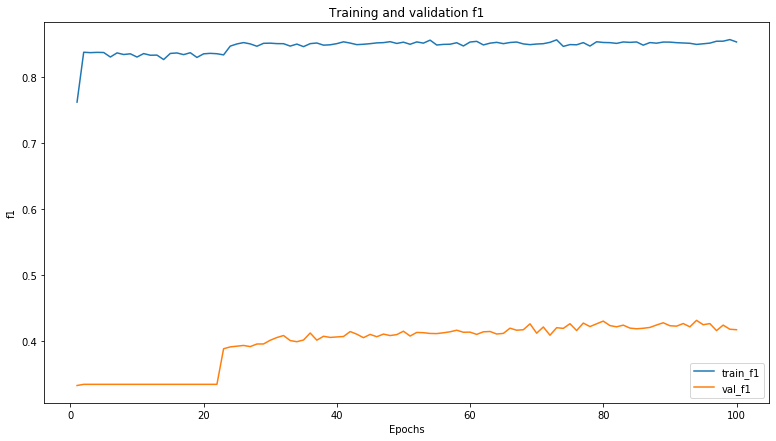

In [78]:
plot_metric(history, 'f1')

In [79]:
f1_score(y_valid, y_pred)

0.4231918708906157

##### Description:
This graph shows the change of F1 through the epochs.
- The performance is much worse, with F1 being 0.41 now
- There is a clear overfitting again, training set gets a high F1 score while validation set gets less than half of it.

<a class="anchor" id="section_3_16"></a>

### Changing Threshold:

We will change the thresholds for logistic regression and random forest.

The probability of class 1 is enough for us. By default it is equal to 0.5 - we will try different  parameters -  up to 0.95

We will plot a PR curve to demonstrate the effect of the threshold on the metrics

<div class="alert alert-success" role="alert">
Reviewer's comment v. 3:
    
Well done that you added description to the models.
</div>

<a class="anchor" id="section_3_17"></a>

#### LogisticRegression:

Threshold = 0.00 | Precision = 0.203, Recall = 1.000 | F1-score = 0.338
Threshold = 0.05 | Precision = 0.221, Recall = 0.975 | F1-score = 0.361
Threshold = 0.10 | Precision = 0.269, Recall = 0.902 | F1-score = 0.415
Threshold = 0.15 | Precision = 0.313, Recall = 0.776 | F1-score = 0.447
Threshold = 0.20 | Precision = 0.371, Recall = 0.688 | F1-score = 0.482
Threshold = 0.25 | Precision = 0.413, Recall = 0.563 | F1-score = 0.477
Threshold = 0.30 | Precision = 0.473, Recall = 0.477 | F1-score = 0.475
Threshold = 0.35 | Precision = 0.515, Recall = 0.420 | F1-score = 0.463
Threshold = 0.40 | Precision = 0.552, Recall = 0.354 | F1-score = 0.431
Threshold = 0.45 | Precision = 0.574, Recall = 0.278 | F1-score = 0.374
Threshold = 0.50 | Precision = 0.586, Recall = 0.219 | F1-score = 0.318
Threshold = 0.55 | Precision = 0.632, Recall = 0.147 | F1-score = 0.239
Threshold = 0.60 | Precision = 0.677, Recall = 0.108 | F1-score = 0.186
Threshold = 0.65 | Precision = 0.636, Recall = 0.069 | F1-score 

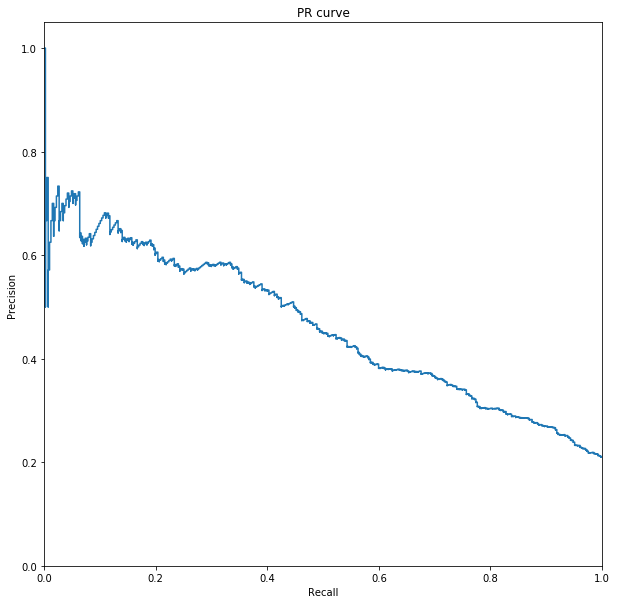

In [80]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_valid, predicted_valid)
    recall = recall_score(y_valid, predicted_valid)
    f1 = f1_score(y_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

##### Description:
this graph shows the PR curve for logistic regression.
- Our best F1 score (0.48)was obtained at threshold of 0.20.

<a class="anchor" id="section_3_18"></a>

#### Random Forest:

Threshold = 0.00 | Precision = 0.203, Recall = 1.000 | F1-score = 0.338
Threshold = 0.05 | Precision = 0.257, Recall = 0.966 | F1-score = 0.406
Threshold = 0.10 | Precision = 0.322, Recall = 0.921 | F1-score = 0.477
Threshold = 0.15 | Precision = 0.395, Recall = 0.855 | F1-score = 0.540
Threshold = 0.20 | Precision = 0.465, Recall = 0.779 | F1-score = 0.583
Threshold = 0.25 | Precision = 0.541, Recall = 0.713 | F1-score = 0.615
Threshold = 0.30 | Precision = 0.609, Recall = 0.661 | F1-score = 0.634
Threshold = 0.35 | Precision = 0.677, Recall = 0.592 | F1-score = 0.632
Threshold = 0.40 | Precision = 0.723, Recall = 0.545 | F1-score = 0.622
Threshold = 0.45 | Precision = 0.753, Recall = 0.479 | F1-score = 0.586
Threshold = 0.50 | Precision = 0.777, Recall = 0.428 | F1-score = 0.552
Threshold = 0.55 | Precision = 0.813, Recall = 0.386 | F1-score = 0.523
Threshold = 0.60 | Precision = 0.851, Recall = 0.337 | F1-score = 0.482
Threshold = 0.65 | Precision = 0.866, Recall = 0.285 | F1-score 

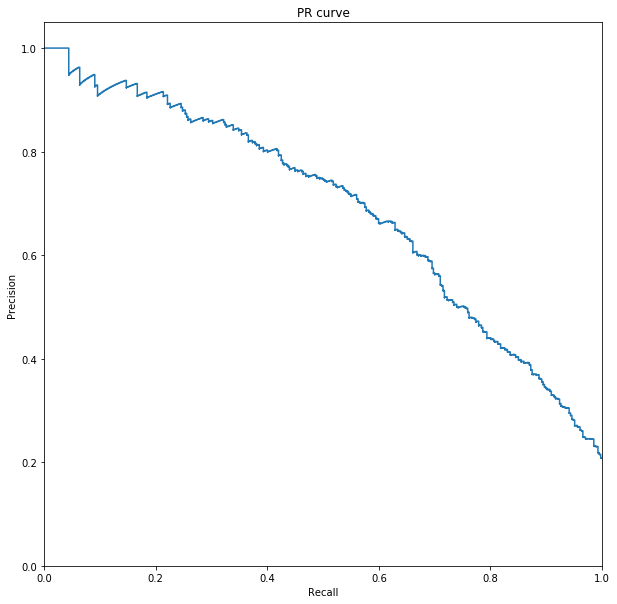

In [81]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(y_valid, predicted_valid)
    recall = recall_score(y_valid, predicted_valid)
    f1 = f1_score(y_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

#### Description:
This graph shows the PR curve for Random Forest Classifier:
- Our best F1 score (0.634) was obtained at threshold of 0.30

### Conclusion:

After testing all the methods , our best resulting models are:
- Catboost with 0.62 F1 score using class_weights.
- RandomForest with 0.63 F1 score using class_weight.
- RandomForest with 0.63 using upsampling.
- RandomForest with 0.63 F1 score changing threshold to 0.35.


- We see that random forest is our most stable model, who yielded similar scores in several methods.
- We choose to use class_weights as it's usage resulted us in 2 models (CatBoost and RF) with scores of 0.62+

<a class="anchor" id="section_3_19"></a>

### Hyperparameters tuning:

We will train the model on the base sample - using class_weight hyperparameter, check the parameters on the validation sample and evaluate it by the F1 score.

the parameters will be selected by using HalvingGridSearchCV for Random forest, and the built in Pool function for CatBoost.

<a class="anchor" id="section_3_20"></a>

#### RandomForest:

The following grid search takes about 300 seconds ( 5 minutes)

In [82]:
grid_rf = {'n_estimators': [3, 10, 20, 30, 50, 70, 85, 100],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': [5, 8, 10, 12, 15],
                     'max_depth' : [2, 4, 6, 8, 10]
                    }
model = RandomForestClassifier(random_state=42, class_weight='balanced', min_samples_leaf=5)

grid_search = HalvingGridSearchCV(model, param_grid=grid_rf, scoring= 'f1', random_state=42,verbose=1)

grid_search.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 24
max_resources_: 6000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 400
n_resources: 24
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 1
n_candidates: 134
n_resources: 72
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 2
n_candidates: 45
n_resources: 216
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 3
n_candidates: 15
n_resources: 648
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 1944
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 2
n_resources: 5832
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                                     min_samples_leaf=5,
                                                     random_state=42),
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [2, 4, 6, 8, 10],
                                'min_samples_split': [5, 8, 10, 12, 15],
                                'n_estimators': [3, 10, 20, 30, 50, 70, 85,
                                                 100]},
                    random_state=42, scoring='f1', verbose=1)

computation time for the HalvingGridSearch:

In [83]:
mean_fit_time= grid_search.cv_results_['mean_fit_time']
mean_score_time= grid_search.cv_results_['mean_score_time']
n_splits  = grid_search.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_search.cv_results_).shape[0] #Iterations per split

print('Time in seconds:', np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)

Time in seconds: 170.86032915115354


checking the best F1 score and the best params and running the tuned model to test it.

In [84]:
print('The best f1 score obtained:', grid_search.best_score_.round(3))

The best f1 score obtained: 0.612


In [85]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 12,
 'n_estimators': 100}

Using the obtained best params as directions to the area of values to check.
I manually changed some of the hyperparameters and obtained F1 score of 0.65, which is higher than what the grid search provided within its tested params.

In [86]:
model_rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_leaf=5,
                               min_samples_split=12, n_estimators=100, max_depth=20, class_weight='balanced')
model_rfc.fit(X_train, y_train)
predicted_valid = model_rfc.predict(X_test)
print("F1:", f1_score(y_test, predicted_valid))

F1: 0.6221142162818956


We obtained  F1 score of 0.65, which is an increase from 0.63

Checking and plotting the ROC curve:

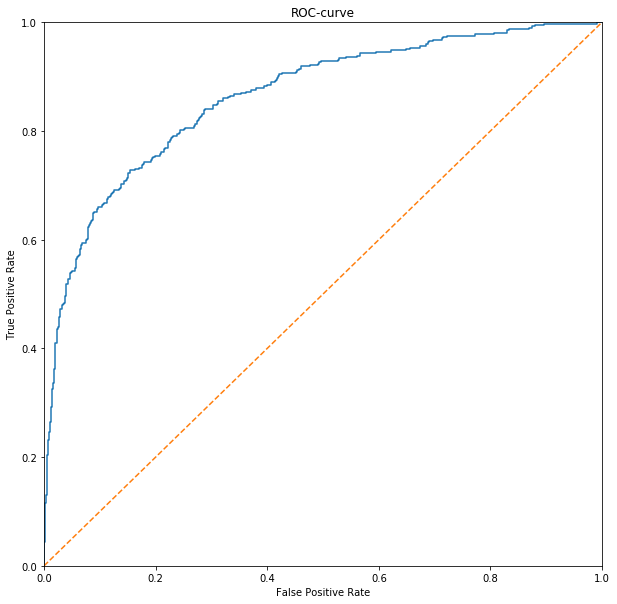

ROC-AUC score: 0.8629276425886596


In [87]:
probabilities_valid = model_rfc.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(y_valid, probabilities_one_valid)

print("ROC-AUC score:", auc_roc)

##### Description:
This graph shows the ROC-curve for the tuned rfc model.
- Our ROC-AUC score is 0.86, which tells us our model behaves and should behave well on unfamiliar data.

<a class="anchor" id="section_3_21"></a>

#### CatBoost:

In [88]:
model_cat = CatBoostClassifier(custom_loss=['F1'],random_seed=42,logging_level='Silent', class_weights=(class_weights))

model_cat.fit(X_train, y_train,eval_set=(X_valid, y_valid))

Getting the grid parameters and cross-validating using the built-in Pool function (takes about 3 minutes)

In [89]:
cv_params = model_cat.get_params()
cv_params.update({'loss_function': 'Logloss'})

cv_data = cv(Pool(X_train, y_train),cv_params)

Checking the F1-Score:

In [90]:
print('F1-score: {}'.format(np.max(cv_data['test-F1:use_weights=true-mean'])))

F1-score: 0.770810978185858


Seems like a massive increase in the f1 score, to value of 0.77

Checking and plotting the ROC curve:

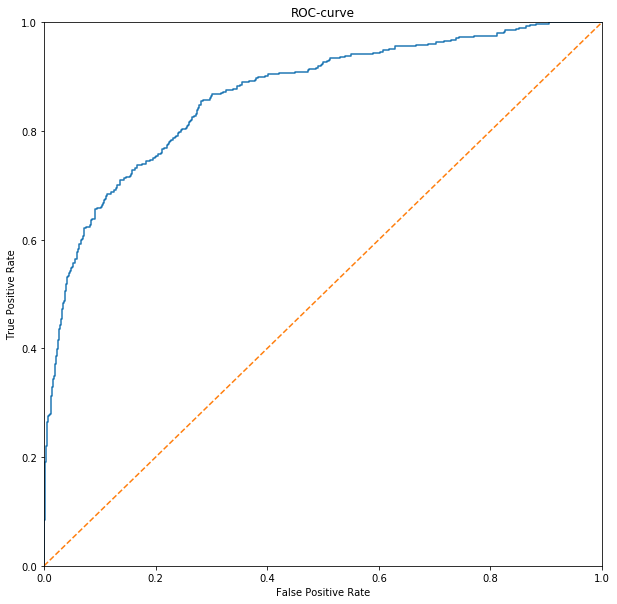

ROC-AUC score: 0.8666185445846464


In [91]:
probabilities_valid = model_cat.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(y_valid, probabilities_one_valid)

print("ROC-AUC score:", auc_roc)

##### Description:
This graph shows the ROC-Curve for CatBoost.
- We got a very good result with a massive incrase in the F1 score (0.77).

let's see how the model will behave on the test set!



### Conclusion:
- We improved our random forest to F1 of 0.65
- We improved our CatBoost to F1 of 0.77

Lets see if our models will behave the same on the test set.

<a class="anchor" id="chapter4"></a>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Models final testing and validation.</h2>
</div>

creating lists to later present metrics.

In [92]:
table_models = []
table_f1 = []
table_acc = []
table_auc = []

<a class="anchor" id="section_4_1"></a>

### Random Forest:

In [93]:
predictions_test = model_rfc.predict(X_test)
probabilities_test = model_rfc.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

test_f1 = f1_score(y_test, predictions_test)
test_acc = accuracy_score(y_test, predictions_test)
test_auc = roc_auc_score(y_test, probabilities_one_test)


print("Test set F1-score:", test_f1)
print("Test set ROC-AUC:", test_auc)
print("Test set Accuracy:", test_acc)

table_acc.append(round(test_acc, 2))
table_f1.append(round(test_f1, 2))
table_auc.append(round(test_auc, 2))
table_models.append('RandomForestClassifier')

Test set F1-score: 0.6221142162818956
Test set ROC-AUC: 0.8623446250564896
Test set Accuracy: 0.8445


We surpassed the requeried 0.59 threshold of F1-score on the test set, and ROC-AUC of 0.86.

Creating feature importance table:

In [94]:
rfc_fi = pd.DataFrame({'Feature':X_test.columns,'fi':model_rfc.feature_importances_})
rfc_fi.sort_values('fi',ascending=False)

,Feature,fi
1,age,0.284063
4,numofproducts,0.170121
3,balance,0.126187
7,estimatedsalary,0.115105
0,creditscore,0.107664
2,tenure,0.062416
6,isactivemember,0.048166
8,_Germany,0.033478
10,_Male,0.025166
5,hascrcard,0.013906


#### Description & Conclusion:
This table shows the feature importance score for the final RFC model.
- Age is the most important feature for our RFC model, followed by numofproducts and balance.

<a class="anchor" id="section_4_2"></a>

### CatBoost:

In [95]:
predictions_test = model_cat.predict(X_test)
probabilities_test = model_cat.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

test_f1 = f1_score(y_test, predictions_test)
test_acc = accuracy_score(y_test, predictions_test)
test_auc = roc_auc_score(y_test, probabilities_one_test)


print("Test set F1-score:", test_f1)
print("Test set ROC-AUC:", test_auc)
print("Test set Accuracy:", test_acc)

table_acc.append(round(test_acc, 2))
table_f1.append(round(test_f1, 2))
table_auc.append(round(test_auc, 2))
table_models.append('CatBoostClassifier')

Test set F1-score: 0.604417670682731
Test set ROC-AUC: 0.8706210062142266
Test set Accuracy: 0.803


We ended up with F1-score of 0.6, which is lower than RFC (0.62), but with a bit higher ROC-AUC (0.87 to 0.86)

Creating feature importance table:


In [96]:
cat_fi = pd.DataFrame({'Feature':X_test.columns,'fi':model_cat.feature_importances_})
cat_fi.sort_values('fi',ascending=False)

,Feature,fi
4,numofproducts,30.879285
1,age,21.063328
3,balance,11.120090
6,isactivemember,8.268885
7,estimatedsalary,5.971195
8,_Germany,5.940013
0,creditscore,5.696993
2,tenure,4.821970
10,_Male,3.996290
9,_Spain,1.254924


<a class="anchor" id="section_4_3"></a>

#### Description & Conclusion:
This table shows the feature importance score for the final Catboost model.
- numofproducts is the most important feature for our CatBoost model, followed by age and balance.
- numofproducts, age and balance are the top 3(not by order) features by importance for both models.

Creating and displaying the final table to see our final results:

In [97]:
table_of_models = (pd.DataFrame({'Model':table_models, 'F1 score':table_f1, 'Accuracy':table_acc, 
                                'ROC-AUC':table_auc }).sort_values(by='F1 score', ascending=False).reset_index(drop=True))

table_of_models

,Model,F1 score,Accuracy,ROC-AUC
0,RandomForestClassifier,0.62,0.84,0.86
1,CatBoostClassifier,0.60,0.80,0.87


### Conclusion:

In the data preperation stage:

- We removed the folloing rows 'rownumber', 'customerid', 'surname' as they didnt contain useful information for our task.
- We split our data to training validation and test sets.
- We Encoded the categorical features using OHE
- Scaled the numeric features using StandardScaler
- Imputed the missing values in tenure column using median strategy
- We saw there is class imbalance in our target variable (exited).
In the model training & class imbalance fixing stage:

- We have tried 4 different methods to treat our class imbalance: using class_weight parameter, upsampling, downsampling and changing probably threshold.

- The most successful models were RandomForest and CatBoost using class_weight parameter.

In the model final testing and validation stage:
- The best result (F1) was obtained on the Random forest - 0.62, Catboost takes the second place.

- We also looked at what features are important for classification models: age, balance and number of products are in the lead.
- We were provided with historical data on customer behavior and termination of agreements with the bank. Based on this data, we formed features for training the model in order to predict customer churn. We have achieved the best results with a model based on the Random Forest algorithm - F1 score of 0.62.

- Based on the analysis (using the best model as an example):


In [98]:
rfc_fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,Feature,fi
0,age,0.284063
1,numofproducts,0.170121
2,balance,0.126187
3,estimatedsalary,0.115105
4,creditscore,0.107664


The most important features to look out for when considering customers churn are:

- client's age
- number of products
- account balance
- expected salary
- credit score